In [1]:
import os, pickle, sys
import torch
import numpy as np
import loadVim as lv
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def getDirections(model, image, label):
    image.requires_grad = True
    model.zero_grad()
    model.eval()
    output = model(image)
    loss = torch.nn.CrossEntropyLoss()(output.logits, label)
    loss.backward()

    gradient = image.grad
    randvec = torch.randn_like(gradient)

    # Normalize the directions
    gradient = gradient / torch.norm(gradient)
    randvec = randvec / torch.norm(randvec)
    return copy.deepcopy(gradient), randvec

In [3]:
def calcGrids(model, image, label, scale=1, num_points=11, directions=None):
    if directions is not None:
        gradient, randvec = directions
    else:
        gradient, randvec = getDirections(model, image, label)

    # scale the directions
    gradient *= scale
    randvec *= scale

    # Calculate loss for all points in neighborhood of image
    X, Y = list(np.linspace(-1, 1, num_points)), list(np.linspace(-1, 1, num_points))
    # for each element in X, multiply by gradient
    XX = [gradient * eps for eps in X]
    YY = [randvec * eps for eps in Y]

    lossgrid = np.zeros((len(XX), len(YY)))
    classgrid = np.zeros((len(XX), len(YY)))
    for i in range(len(XX)):
        for j in range(len(YY)):
            perturbed_image = image + XX[i] + YY[j]
            # get loss of each perturbed image
            output = model(perturbed_image)
            loss = torch.nn.CrossEntropyLoss()(output.logits, label)
            lossgrid[i][j] = loss
            classgrid[i][j] = torch.argmax(output.logits).item()
    
    X, Y = np.meshgrid(X, Y)
    
    return X, Y, lossgrid, classgrid

In [4]:
def plotLossLandscape(X, Y , lossgrid, title):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, lossgrid, cmap=cm.coolwarm)
    ax.set_xlabel('ε perturbation along v1')     
    ax.set_ylabel('ε perturbation along v2')
    ax.set_zlabel('Loss')
    ax.set_title(title)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    plt.show()
    

In [5]:
def plotDecisionBoundary(classgrid):
    # Plot the class grid with each distinct class having a distinct color
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    ax.imshow(classgrid, cmap='plasma', origin="lower")
    # set x and y ticks to be the same from -1 to 1
    ax.set_xticks(np.linspace(0, classgrid.shape[0]-1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3))
    ax.set_yticks(np.linspace(0, classgrid.shape[1]-1, 3))
    ax.set_yticklabels(np.linspace(-1, 1, 3))
    ax.set_xlabel('ε perturbation along v1')     
    ax.set_ylabel('ε perturbation along v2')
    ax.set_title("Class Landscape of Image")
    plt.show()

In [6]:
def plotBoth(X, Y, lossgrid, classgrid, title="Image Neighborhood Analysis"):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(14, 7)
    axs[0].imshow(classgrid, cmap='plasma', origin="lower")
    axs[0].set_xticks(np.linspace(0, classgrid.shape[0]-1, 3))
    axs[0].set_xticklabels(np.linspace(-1, 1, 3))
    axs[0].set_yticks(np.linspace(0, classgrid.shape[1]-1, 3))
    axs[0].set_yticklabels(np.linspace(-1, 1, 3))
    axs[0].set_xlabel('ε perturbation along v1')     
    axs[0].set_ylabel('ε perturbation along v2')
    axs[0].set_title("Class Landscape of Image Neighborhood")
    
    # Hide axes for the second plot
    axs[1].axis('off')
    axs[1] = fig.add_subplot(122, projection='3d')
    axs[1].plot_surface(X, Y, lossgrid, cmap=cm.coolwarm)
    axs[1].set_xlabel('ε perturbation along v1')     
    axs[1].set_ylabel('ε perturbation along v2')
    axs[1].set_zlabel('Loss')
    axs[1].set_title("Loss Landscape of Image Neighborhood")
    axs[1].set_box_aspect(aspect=None, zoom=0.85)
    
    # Add overall title
    fig.suptitle(title)
    
    plt.show()

In [7]:
model, processor = lv.prepareDownstreamVit()
transform = transforms.Compose([
        lambda image: processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
    ])

path_data = os.path.join(os.getcwd(), 'CelebSubset/CelebVal')
path_checkpoint = os.path.join(os.getcwd(), 'models/VitA.pth')

dataset = datasets.ImageFolder(path_data, transform = transform)

loader = DataLoader(dataset, batch_size=1, shuffle=False)

checkpoint = torch.load(path_checkpoint)
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device)

image, label = next(iter(loader))
image = image.to(device)
label = label.to(device)

# Demo of loss landscape

In [8]:
gradient, randvec = getDirections(model, image, label)

In [9]:
# High numpoints makes it a lot slower
X, Y, lossgrid, classgrid = calcGrids(model, image, label, scale=1e3, num_points=20, directions=(gradient, randvec))


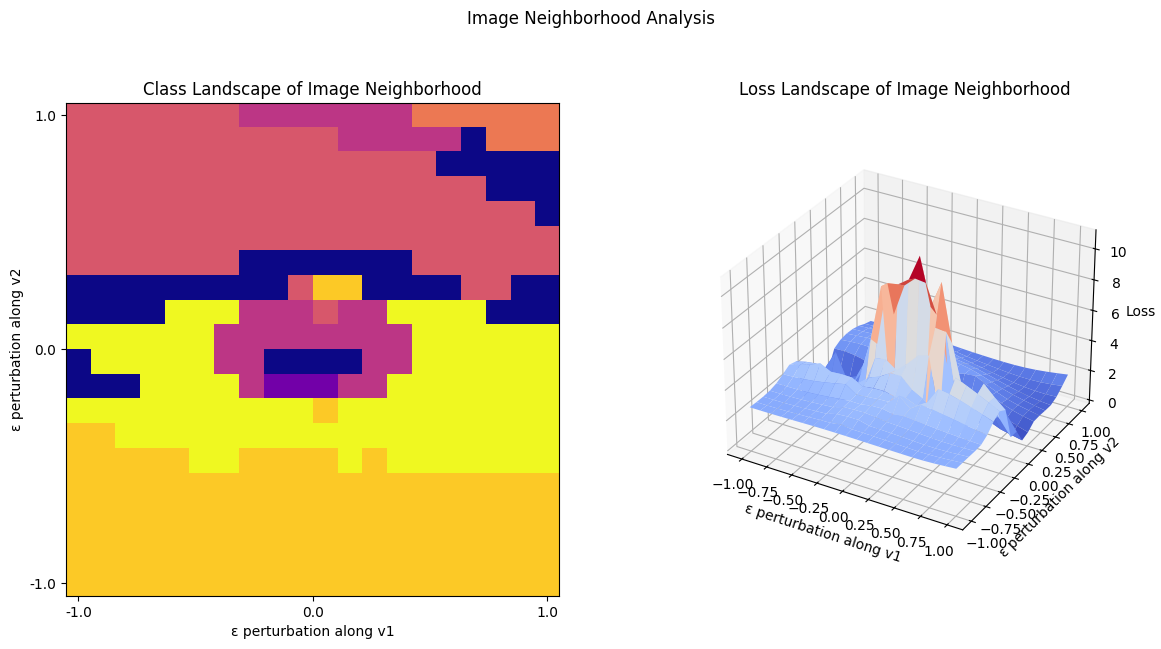

In [10]:
plotBoth(X, Y, lossgrid, classgrid)

# Landscape difference before and after adversarial

In [11]:
# Load dataset
path_data = os.path.join(os.getcwd(), 'CelebSubset/CelebTest')
dataset = datasets.ImageFolder(path_data, transform = transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

image, label = next(iter(loader))
image = image.to(device)
label = label.to(device)

# Load model0 (before adversarial training)
model0, processor = lv.prepareDownstreamVit()
transform = transforms.Compose([lambda image: processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)])
path_checkpoint = os.path.join(os.getcwd(), 'models/VitA.pth')
checkpoint = torch.load(path_checkpoint)
model0.load_state_dict(checkpoint["state_dict"])
model0 = model0.to(device)

# Load model1 (after adversarial training)
model1, processor = lv.prepareDownstreamVit()
transform = transforms.Compose([lambda image: processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)])
path_checkpoint = os.path.join(os.getcwd(), 'models/AdvVitA.pth')
checkpoint = torch.load(path_checkpoint)
model1.load_state_dict(checkpoint["state_dict"])
model1 = model1.to(device)


In [12]:
grad0, randvec = getDirections(model0, image, label)
grad1, _ = getDirections(model1, image, label)

In [13]:
# Dot product indicates gradients near parallel
print("dot grads ", torch.dot(grad0.view(-1), grad1.view(-1)).item())

dot grads  0.9938371777534485


In [14]:
X0, Y0, lossgrid0, classgrid0 = calcGrids(model0, image, label, scale=1e3, num_points=20, directions=(grad0, randvec))

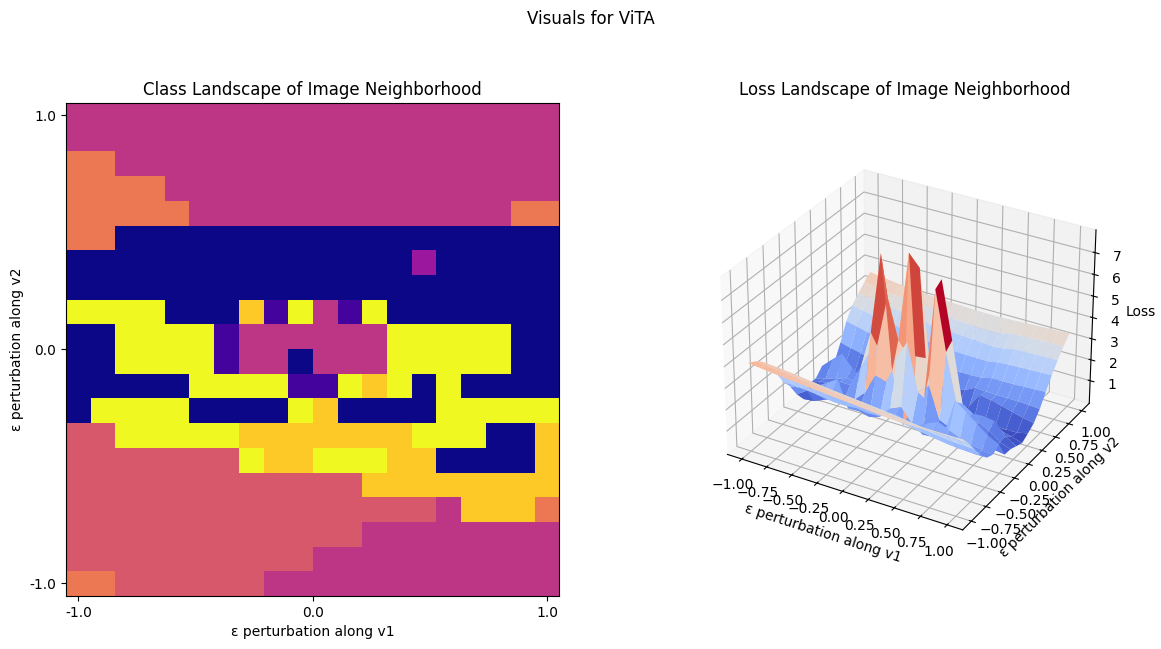

In [15]:
plotBoth(X0, Y0, lossgrid0, classgrid0, title="Visuals for ViTA") 

In [16]:
X1, Y1, lossgrid1, classgrid1 = calcGrids(model1, image, label, scale=1e3, num_points=20, directions=(grad0, randvec))

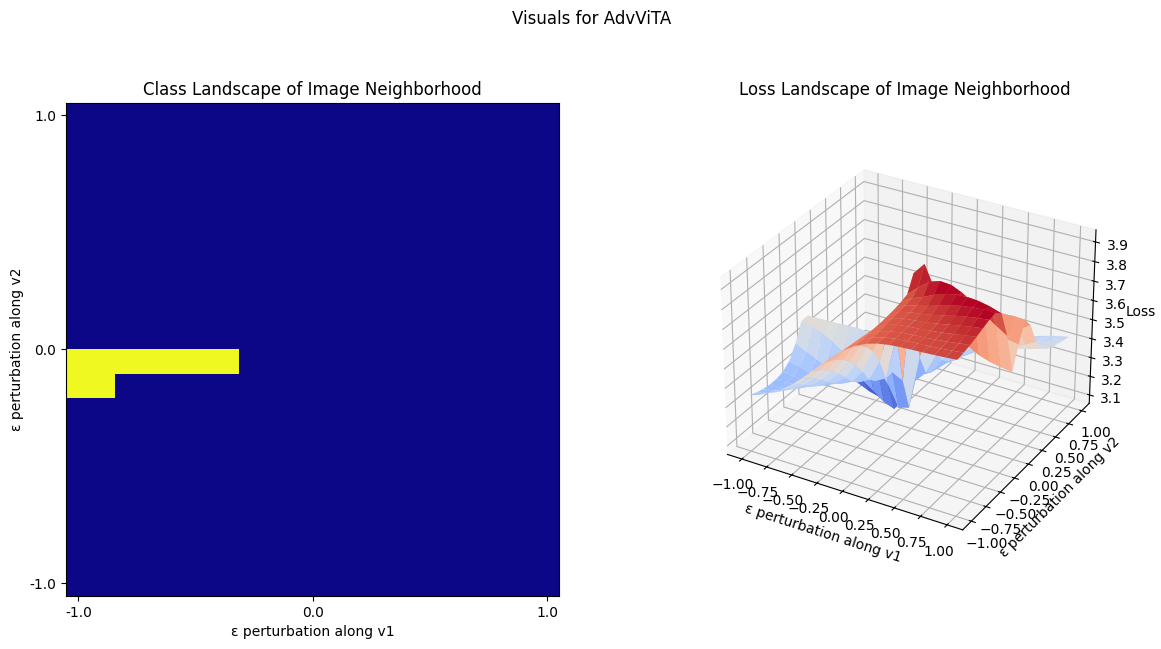

In [17]:
plotBoth(X1, Y1, lossgrid1, classgrid1, title="Visuals for AdvViTA") 